# Определение перспективного тарифа для телеком компании


### Краткий план работы:
#### Шаг 1. Открытие файлов и описание данных:
- открытие файлов с данными и изучение общей информации
- предметное описание столбцов

#### Шаг 2. Подготовка данных:
- приведение данных к нужным типам
- нахождение и исправление ошибок в данных
- расчёт количества сделанных звонков и израсходованных минут разговора по месяцам для каждого клиента
- расчёт количества отправленных сообщений по месяцам для каждого клиента
- расчёт объема израсходованного интернет-трафика по месяцам для каждого клиента
- расчёт месячной выручки с каждого клиента

#### Шаг 3. Описание поведения клиентов оператора, исходя из выборки:
- расчёт требуемого количества минут, сообщений и интернет-трафика в месяц для пользователей каждого тарифа
- расчёт статистических данных
- построение гистограм
- описание распределений

#### Шаг 4. Проверка гипотез: 
- гипотеза 1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
- гипотеза 2: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

#### Шаг 5. Общий вывод.
<br>


### Шаг 1. Открытие файлов и описание данных

Подключим используемые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats as st

Откроем файлы данных, посмотрим шапку и общую информацию. Опишем данные.

**Таблица _users_ (информация о пользователях):**

In [2]:
users = pd.read_csv('/datasets/users.csv')
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Описание столбцов:
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

С первого взгляда данные неплохо подготовлены. Явных пропусков не обнаружено (churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)). <br>
<br>При дальнейшей обработке:
- преобразуем дату к формату datetime
- преобразуем возраст к целочисленному значению
- проверим корректность написания городов и названий тарифов
- проверим данные на наличие дубликатов

**Таблица _tariffs_ (информация о тарифах):**

In [4]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.head(10)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Описание столбцов:
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Таблица с данными о тарифах ожидаемо не содержит ошибок. Она не является выборкой, это информация о тарифах в табличном виде.

**Таблица _calls_ (информация о звонках):**

In [5]:
calls = pd.read_csv('/datasets/calls.csv')
calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [6]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Описание столбцов:
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

В данных видно много нулевых значений в столбце длительности звонка. Вероятно они появились при недозвоне. <br>

При дальнейшей обработке:
- преобразуем дату к формату datetime
- разберёмся с вызовами нулевой длительности
- проверим наличие дубликатов

**Таблица _messages_ (информация о сообщениях):**

In [7]:
messages = pd.read_csv('/datasets/messages.csv')
messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [8]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Описание столбцов:
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

В данных нет пропусков. <br>

При дальнейшей обработке:
- преобразуем дату к формату datetime
- проверим наличие дубликатов

**Таблица _internet_ (информация об интернет-сессиях):**

In [9]:
internet = pd.read_csv('/datasets/internet.csv')
internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [10]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Описание столбцов:
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

В данных нет пропусков. <br>

При дальнейшей обработке:
- преобразуем дату к формату datetime
- проверим наличие дубликатов

#### Вывод:####
Открыли все файлы данных, посмотрели на первые 10 строк каждой таблицы и оценили общую информацию по каждой. <br>
Видно, что данные хорошо собраны и в большинстве своём не имеют явных недочётов (пропусков / дубликатов). <br>
Но, всё же, необходимо выполнить некоторую предобработку данных:
- привести дату к общему формату datetime
- проверить все таблицы на наличие дубликатов
- разобраться с вызовами нулевой длительности
- в таблице users преобразовать возраст к целочисленному значению
- в таблице users проверить корректность написания городов и названий тарифов
- в таблице users переименовать столбце *tariff* в *tariff_name* для возможности объединения с таблицей тарифов
- объединим таблицы users и tariffs

### Шаг 2. Подготовка данных

Для начала проведём предобработку данных в каждой таблице.

**Таблица _users_**

In [11]:
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


Преобразуем дату к формату *datetime*:

In [12]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [13]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

Преобразуем возраст к целочисленному значению:

In [14]:
users['age'] = users['age'].astype('int')

Проверим корректность написания городов и названий тарифов:

In [15]:
users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

Названия городов написаны в едином стиле, по этому смысловые повторы отсутствуют.

In [16]:
users['tariff'].unique()

array(['ultra', 'smart'], dtype=object)

Лишних данных в столбце тарифов не обнаружено.

Проверим данные на наличие дубликатов

In [17]:
users.duplicated('user_id').sum()

0

Дубликатов в данных не обнаружено. Также это означает, что каждый *user_id* имеет **один тариф** на всём протяжении наблюдений. Стоит отметить достаточно хорошую организацию сбора данных. Вероятно, при вводе данных пользователя, поля "город" и "тариф" предлагают выбрать вариант из списка. При вводе даты происходит проверка формата. Форма ввода возраста может принимать только числовые значения.

Переименуем столбец с названием тарифов:

In [18]:
users.rename(columns=lambda x: x.replace('tariff', 'tariff_name'), inplace=True)

Посмотрим общую информацию о таблице с пользователями после обработки:

In [19]:
users.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id        500 non-null int64
age            500 non-null int64
churn_date     38 non-null datetime64[ns]
city           500 non-null object
first_name     500 non-null object
last_name      500 non-null object
reg_date       500 non-null datetime64[ns]
tariff_name    500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [20]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Предобработка данных в этой таблице выполнена корректно.

Объединим таблицы пользователей и их тарифов:

In [21]:
users_tariffs = pd.merge(users, tariffs, on='tariff_name')

In [22]:
users_tariffs.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1
2,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,1000,30720,3000,1950,150,1,1
3,1013,36,NaT,Иваново,Борис,Андреенко,2018-11-14,ultra,1000,30720,3000,1950,150,1,1
4,1016,58,NaT,Омск,Марица,Сазонова,2018-11-21,ultra,1000,30720,3000,1950,150,1,1


**Таблица _calls_**

In [23]:
calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


Преобразуем дату к формату *datetime*:

In [24]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

Проверим наличие дубликатов:

In [25]:
calls.duplicated('id').sum()

0

В столбце длительности вызовов присутствуют нулеввые значения. Посчитаем их: 

In [26]:
calls['duration'].value_counts()[0]

39613

Порядка 20% данных о звонках - с нулевой длительностью. Это много, но эти данные не несут никакой полезной информации: при нулевой длительности звонков пользователи не расходуют минуты и не тратят деньги, по этому удалим их.

In [27]:
calls = calls.query('duration != 0')

**Таблица _messages_**

In [28]:
messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


Преобразуем дату к формату *datetime*:

In [29]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

Проверим наличие дубликатов:

In [30]:
messages.duplicated('id').sum()

0

Дубликатов нет.

**Таблица _internet_**

In [31]:
internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


Преобразуем дату к формату *datetime*:

In [32]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

Проверим наличие сессий с нулевым количеством потреблённого трафика:

In [33]:
internet.query('mb_used == 0').shape[0]

19598

Около 14% интернет сессий без потреблённого трафика. Возможно это заблокированные сессии при недостаточном количестве средств на счету или так оператор обозначил сессии, трафик которых не тарифицируется (например безлимит на социальные сети). Достоверно это можно узнать у оператора. Но для нас эти сессии не несут полезной информации: пользователи не расходуют пакеты трафика и не расходуют средства. Поэтому удалим их:

In [34]:
internet = internet.query('mb_used != 0')

На данном этапе мы привели данные к нужным типам, нашли и исправили ошибки в данных. <br>
Далее рассчитаем и **добавим в таблицу новые признаки**.
Рассчитаем количество сделанных звонков и израсходованных минут разговора по месяцам для каждого клиента и добавим название тарифа:

In [35]:
calls.head()

,id,call_date,duration,user_id
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000


Проверим, что месяца не повторяются (информация представлена не более чем за год):

In [36]:
calls['call_date'].describe()

count                  162994
unique                    365
top       2018-12-31 00:00:00
freq                     1173
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: call_date, dtype: object

Добавим тариф:

In [37]:
calls = pd.merge(calls, users[['user_id', 'tariff_name']], on='user_id')

Для группировки, добавим столбец с номером месяца в таблицу:

In [38]:
calls['month'] = calls['call_date'].dt.month

In [39]:
user_calls = calls.pivot_table(index=['user_id', 'month', 'tariff_name'], values='duration', aggfunc=['count', 'sum'])
user_calls.columns = ['number_of_calls', 'total_duration']
user_calls.head(10)

number_of_calls  total_duration
user_id month tariff_name                                 
1000    5     ultra                     17          150.06
        6     ultra                     28          158.90
        7     ultra                     41          318.80
        8     ultra                     42          389.87
        9     ultra                     46          440.14
        10    ultra                     44          328.45
        11    ultra                     37          319.04
        12    ultra                     38          312.98
1001    11    smart                     45          408.12
        12    smart                     47          391.34

Посчитаем количество отправленных сообщений по месяцам для каждого пользователя:

In [40]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [41]:
messages['message_date'].describe()

count                  123036
unique                    364
top       2018-12-31 00:00:00
freq                      859
first     2018-01-02 00:00:00
last      2018-12-31 00:00:00
Name: message_date, dtype: object

Добавим тариф:

In [42]:
messages = pd.merge(messages, users[['user_id', 'tariff_name']], on='user_id')

In [43]:
messages['month'] = messages['message_date'].dt.month

In [44]:
user_messages = messages.pivot_table(index=['user_id', 'month', 'tariff_name'], values='id', aggfunc='count')
user_messages.columns = ['total_messages']
user_messages.head(10)

total_messages
user_id month tariff_name                
1000    5     ultra                    22
        6     ultra                    60
        7     ultra                    75
        8     ultra                    81
        9     ultra                    57
        10    ultra                    73
        11    ultra                    58
        12    ultra                    70
1002    6     smart                     4
        7     smart                    11

Посчитаем объем израсходованного интернет-трафика по месяцам для каждого пользователя:

In [45]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Добавим тариф:

In [46]:
internet = pd.merge(internet, users[['user_id', 'tariff_name']], on='user_id')

In [47]:
internet['month'] = internet['session_date'].dt.month

In [48]:
user_internet = internet.pivot_table(index=['user_id', 'month', 'tariff_name'], values='mb_used', aggfunc='sum')
user_internet.columns = ['total_mb_used']
user_internet.head(10)

total_mb_used
user_id month tariff_name               
1000    5     ultra              2253.49
        6     ultra             23233.77
        7     ultra             14003.64
        8     ultra             14055.93
        9     ultra             14568.91
        10    ultra             14702.49
        11    ultra             14756.47
        12    ultra              9817.61
1001    11    smart             18429.34
        12    smart             14036.66

Рассчитаем помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика, остаток умножим на значение из тарифного плана).<br>
Сначала создадим датафрейм с помесячным расходом ресурсов каждого пользователя:

In [49]:
user_monthly_expense = pd.merge(user_calls, user_messages, how='outer', on=['user_id', 'month', 'tariff_name'])
user_monthly_expense = pd.merge(user_monthly_expense, user_internet, how='outer', on=['user_id', 'month', 'tariff_name'])

In [50]:
user_monthly_expense.head(10)

number_of_calls  total_duration  total_messages  \
user_id month tariff_name                                                    
1000    5     ultra                   17.0          150.06            22.0   
        6     ultra                   28.0          158.90            60.0   
        7     ultra                   41.0          318.80            75.0   
        8     ultra                   42.0          389.87            81.0   
        9     ultra                   46.0          440.14            57.0   
        10    ultra                   44.0          328.45            73.0   
        11    ultra                   37.0          319.04            58.0   
        12    ultra                   38.0          312.98            70.0   
1001    11    smart                   45.0          408.12             NaN   
        12    smart                   47.0          391.34             NaN   

                           total_mb_used  
user_id month tariff_name                 
1000    5     ultra              2253.49  
        6     ultra             23233.77  
        7     ultra             14003.64  
        8     ultra             14055.93  
        9     ultra             14568.91  
        10    ultra             14702.49  
        11    ultra             14756.47  
        12    ultra              9817.61  
1001    11    smart             18429.34  
        12    smart             14036.66

Преобразуем индексы для возможности объединения таблиц:

In [51]:
user_monthly_expense = user_monthly_expense.reset_index(level=['tariff_name', 'month', 'user_id'])

In [52]:
user_monthly_expense.head(10)

,user_id,month,tariff_name,number_of_calls,total_duration,total_messages,total_mb_used
0,1000,5,ultra,17.0,150.06,22.0,2253.49
1,1000,6,ultra,28.0,158.90,60.0,23233.77
2,1000,7,ultra,41.0,318.80,75.0,14003.64
3,1000,8,ultra,42.0,389.87,81.0,14055.93
4,1000,9,ultra,46.0,440.14,57.0,14568.91
5,1000,10,ultra,44.0,328.45,73.0,14702.49
6,1000,11,ultra,37.0,319.04,58.0,14756.47
7,1000,12,ultra,38.0,312.98,70.0,9817.61
8,1001,11,smart,45.0,408.12,NaN,18429.34
9,1001,12,smart,47.0,391.34,NaN,14036.66


Заметим, что некоторые пользователине совершали тарифицируемых действий в определённые месяцы, заполним пропуски нулями:

In [53]:
user_monthly_expense = user_monthly_expense.fillna(0)

Объединим:

In [54]:
user_monthly_expense = pd.merge(user_monthly_expense, tariffs, on='tariff_name')
user_monthly_expense.head(10)

,user_id,month,tariff_name,number_of_calls,total_duration,total_messages,total_mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,ultra,17.0,150.06,22.0,2253.49,1000,30720,3000,1950,150,1,1
1,1000,6,ultra,28.0,158.90,60.0,23233.77,1000,30720,3000,1950,150,1,1
2,1000,7,ultra,41.0,318.80,75.0,14003.64,1000,30720,3000,1950,150,1,1
3,1000,8,ultra,42.0,389.87,81.0,14055.93,1000,30720,3000,1950,150,1,1
4,1000,9,ultra,46.0,440.14,57.0,14568.91,1000,30720,3000,1950,150,1,1
5,1000,10,ultra,44.0,328.45,73.0,14702.49,1000,30720,3000,1950,150,1,1
6,1000,11,ultra,37.0,319.04,58.0,14756.47,1000,30720,3000,1950,150,1,1
7,1000,12,ultra,38.0,312.98,70.0,9817.61,1000,30720,3000,1950,150,1,1
8,1003,8,ultra,43.0,355.67,37.0,8565.21,1000,30720,3000,1950,150,1,1
9,1003,9,ultra,105.0,904.89,91.0,12468.87,1000,30720,3000,1950,150,1,1


Добавим в таблицу столбцы с количеством минут/сообщений/трафика израсходованного в текущем месяце сверх пакета. Назовём столбцы *duration_over_limit*, *messages_over_limit*, *internet_over_limit* соответственно

In [55]:
user_monthly_expense['duration_over_limit'] = user_monthly_expense.apply(
    lambda row: row['total_duration'] - row['minutes_included'] 
    if (row['total_duration'] > row['minutes_included']) else 0, 
    axis=1)

In [56]:
user_monthly_expense['messages_over_limit'] = user_monthly_expense.apply(
    lambda row: row['total_messages'] - row['messages_included'] 
    if (row['total_messages'] > row['messages_included']) else 0, 
    axis=1)

In [57]:
user_monthly_expense['internet_over_limit'] = user_monthly_expense.apply(
    lambda row: row['total_mb_used'] - row['mb_per_month_included'] 
    if (row['total_mb_used'] > row['mb_per_month_included']) else 0, 
    axis=1)

Доплата за интернет сверх пакета осуществляется кратно 1 Гб. <br>
Переведём значения столбца *internet_over_limit* в гигабайты и округлим в большую сторону:

In [58]:
user_monthly_expense['internet_over_limit'] = np.ceil(user_monthly_expense['internet_over_limit'] / 1024)

Теперь рассчитаем сколько денег потратили пользователи сверх абонентской платы:

In [59]:
user_monthly_expense['expenses_over_fee'] = user_monthly_expense.apply(
    lambda row: row['duration_over_limit'] * row['rub_per_minute'] + 
    row['messages_over_limit'] * row['rub_per_message'] +
    row['internet_over_limit'] * row['rub_per_gb'], 
    axis=1)

И посчитаем сколько всего денег в месяц потратил каждый пользователь:

In [60]:
user_monthly_expense['money_spent'] = user_monthly_expense['expenses_over_fee'] + user_monthly_expense['rub_monthly_fee']

Добавим в таблицу город пользователя. Это пригодится при дальнейшем анализе:

In [61]:
user_monthly_expense = pd.merge(user_monthly_expense, users[['user_id', 'city']], on='user_id')

In [62]:
user_monthly_expense.head(10)

,user_id,month,tariff_name,number_of_calls,total_duration,total_messages,total_mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,duration_over_limit,messages_over_limit,internet_over_limit,expenses_over_fee,money_spent,city
0,1000,5,ultra,17.0,150.06,22.0,2253.49,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0,Краснодар
1,1000,6,ultra,28.0,158.90,60.0,23233.77,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0,Краснодар
2,1000,7,ultra,41.0,318.80,75.0,14003.64,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0,Краснодар
3,1000,8,ultra,42.0,389.87,81.0,14055.93,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0,Краснодар
4,1000,9,ultra,46.0,440.14,57.0,14568.91,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0,Краснодар
5,1000,10,ultra,44.0,328.45,73.0,14702.49,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0,Краснодар
6,1000,11,ultra,37.0,319.04,58.0,14756.47,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0,Краснодар
7,1000,12,ultra,38.0,312.98,70.0,9817.61,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0,Краснодар
8,1003,8,ultra,43.0,355.67,37.0,8565.21,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0,Москва
9,1003,9,ultra,105.0,904.89,91.0,12468.87,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0,Москва


Сгруппируем таблицу по пользователям

In [63]:
user_monthly_expense = user_monthly_expense.pivot_table(index=['user_id', 'tariff_name', 'city'], values=['total_duration', 'total_messages', 'total_mb_used', 'money_spent'])
user_monthly_expense = user_monthly_expense.reset_index(level=['city', 'tariff_name', 'user_id'])

In [64]:
user_monthly_expense.head(10)

,user_id,tariff_name,city,money_spent,total_duration,total_mb_used,total_messages
0,1000,ultra,Краснодар,1950.000000,302.280000,13424.038750,62.0
1,1001,smart,Москва,850.000000,399.730000,16233.000000,0.0
2,1002,smart,Стерлитамак,1035.714286,204.452857,16576.645714,10.0
3,1003,ultra,Москва,1950.000000,720.104000,11456.128000,76.0
4,1004,ultra,Новокузнецк,1950.000000,115.151250,18629.935000,149.0
5,1005,smart,Набережные Челны,752.702500,520.220833,8307.275833,46.0
6,1006,smart,Ульяновск,931.818182,299.032727,14926.255455,0.0
7,1007,smart,Москва,873.634444,459.941111,14625.074444,25.0
8,1008,smart,Челябинск,568.000000,320.840000,13217.140000,56.0
9,1009,smart,Пермь,1310.000000,205.631000,17741.121000,11.0


#### Вывод:####
На данном шаге для каждого пользователя определили месячный расход минут, сообщений и интренет трафика, расход сверх пакета, посчитали сколько заплатили пользователи

### Шаг 3. Описание поведения клиентов оператора, исходя из выборки

На данном шаге опишем поведение клиентов исходя из выборки. <br>
Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы. Опишем распределения.

Посмотрим, сколько в среднем расходуют пользователи разных тарифов

Расход минут:

In [65]:
user_monthly_expense.query('tariff_name == "ultra"')['total_duration'].describe()

count     148.000000
mean      498.278725
std       265.815738
min         0.000000
25%       307.277386
50%       485.295583
75%       704.543611
max      1114.381818
Name: total_duration, dtype: float64

In [66]:
print('Дисперсия равна', round(user_monthly_expense.query('tariff_name == "ultra"')['total_duration'].std()**2))

Дисперсия равна 70658


In [67]:
user_monthly_expense.query('tariff_name == "smart"')['total_duration'].describe()

count    350.000000
mean     396.065388
std      137.026938
min        0.000000
25%      298.953182
50%      400.634375
75%      490.288333
max      842.190000
Name: total_duration, dtype: float64

In [68]:
print('Дисперсия равна', round(user_monthly_expense.query('tariff_name == "smart"')['total_duration'].std()**2))

Дисперсия равна 18776


Пользователи тарифа **Ultra** в среднем разговаривают 498 минут в месяц. Медианное значение 485 минут. Для пользователей тарифа **Samrt** это 396 и 400 минут соответственно. Значит, скорее всего, распределение близко к нормальному в обеих случаях. 
Стандартное отклонение больше на более дорогом тарифе. Это говорит о том, что его пользователи более разнородовые. Кто-то использует этот тариф для звонков, а кто-то, например, переплачивает ради интернета

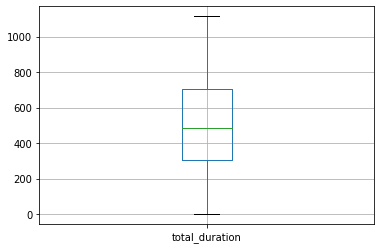

In [69]:
user_monthly_expense.query('tariff_name == "ultra"').boxplot('total_duration');

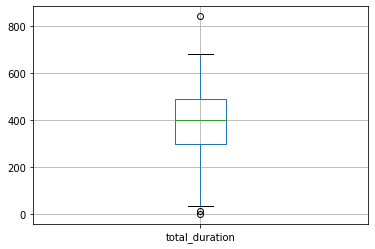

In [70]:
user_monthly_expense.query('tariff_name == "smart"').boxplot('total_duration');

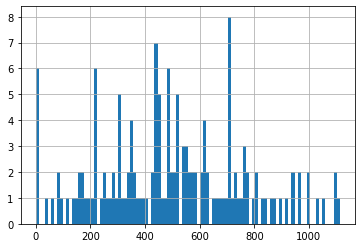

In [71]:
user_monthly_expense.query('tariff_name == "ultra"')['total_duration'].hist(bins=100);

In [72]:
print('Доля людей не использующих звонки на тарифе "Ultra": {:.2%}'.format(user_monthly_expense.query('tariff_name == "ultra" and total_duration == 0').shape[0]/user_monthly_expense.query('tariff_name == "ultra"').shape[0]))

Доля людей не использующих звонки на тарифе "Ultra": 3.38%


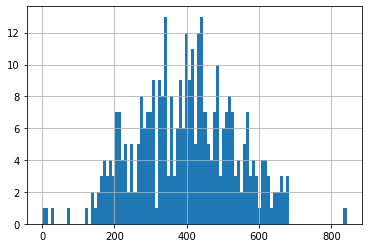

In [73]:
user_monthly_expense.query('tariff_name == "smart"')['total_duration'].hist(bins=100);

Как и ожидалось - распределение похоже на нормальное, с выбросом в нуле. Некоторые пользователи не пользуются звонками вообще. Их гораздо больше среди пользователей дешевого тарифа. Возможно их устройства просто не поддерживают звонки (сим-карты установленные в модемах, планшетах). Логично, что для этой цели используется тариф с большим объемом трафика включенным в абонентскую плату.

Расход сообщений:

In [74]:
user_monthly_expense.query('tariff_name == "ultra"')['total_messages'].describe()

count    148.000000
mean      54.030743
std       46.366246
min        0.000000
25%       17.000000
50%       45.500000
75%       84.250000
max      192.000000
Name: total_messages, dtype: float64

In [75]:
print('Дисперсия равна', round(user_monthly_expense.query('tariff_name == "ultra"')['total_messages'].std()**2))

Дисперсия равна 2150


In [76]:
user_monthly_expense.query('tariff_name == "smart"')['total_messages'].describe()

count    350.000000
mean      32.352078
std       26.512448
min        0.000000
25%       11.000000
50%       27.750000
75%       48.000000
max      118.000000
Name: total_messages, dtype: float64

In [77]:
print('Дисперсия равна', round(user_monthly_expense.query('tariff_name == "smart"')['total_messages'].std()**2))

Дисперсия равна 703


Сообщениями пользователи пользуются мало. Вне зависимости от тарифа.

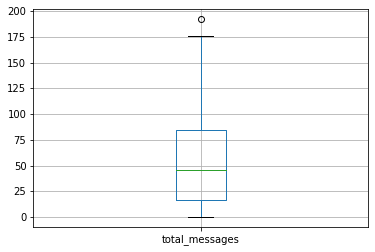

In [78]:
user_monthly_expense.query('tariff_name == "ultra"').boxplot('total_messages');

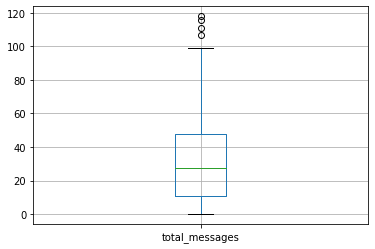

In [79]:
user_monthly_expense.query('tariff_name == "smart"').boxplot('total_messages');

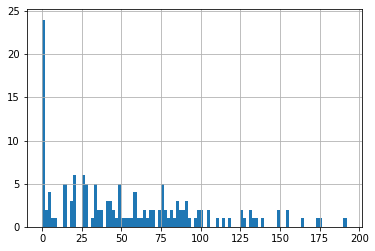

In [80]:
user_monthly_expense.query('tariff_name == "ultra"')['total_messages'].hist(bins=100);

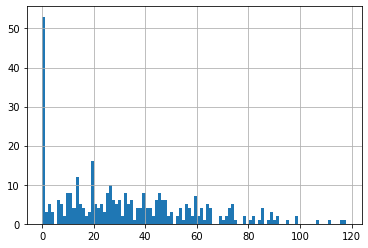

In [81]:
user_monthly_expense.query('tariff_name == "smart"')['total_messages'].hist(bins=100);

Пользователей не использующих сообщения гораздо больше. Вероятно это связано с современной популярностью мессенджеров и социальных сетей.

Расход интернет траффика:

In [82]:
user_monthly_expense.query('tariff_name == "ultra"')['total_mb_used'].describe()

count      148.000000
mean     19574.644589
std       8311.182119
min          0.000000
25%      14491.365045
50%      18699.435500
75%      25883.125000
max      38463.570000
Name: total_mb_used, dtype: float64

In [83]:
print('Дисперсия равна', round(user_monthly_expense.query('tariff_name == "ultra"')['total_mb_used'].std()**2))

Дисперсия равна 69075748


In [84]:
user_monthly_expense.query('tariff_name == "smart"')['total_mb_used'].describe()

count      350.000000
mean     16180.613968
std       3579.221370
min       5384.218182
25%      13916.940357
50%      16250.362714
75%      18595.710972
max      27286.960000
Name: total_mb_used, dtype: float64

In [85]:
print('Дисперсия равна', round(user_monthly_expense.query('tariff_name == "smart"')['total_mb_used'].std()**2))

Дисперсия равна 12810826


А вот интернетом пользуются много. В среднем пользователи расходуют от 16 Гб (на тарифе **Samrt**) до 19.5 Гб (на тарфие **Ultra**). Медианное значение примерно такое же. Значит можно ожидать распределение близкое к нормальному.
Стоит заметить, что разница в количестве потребленного трафика не большая.

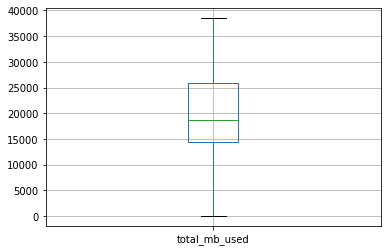

In [86]:
user_monthly_expense.query('tariff_name == "ultra"').boxplot('total_mb_used');

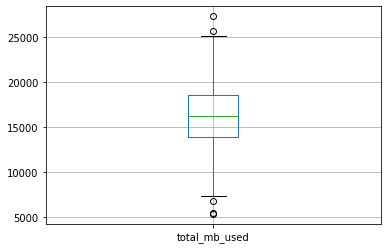

In [87]:
user_monthly_expense.query('tariff_name == "smart"').boxplot('total_mb_used');

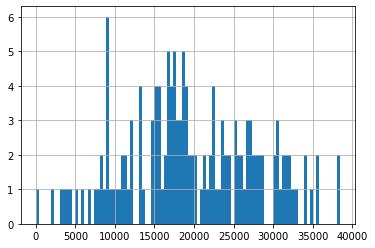

In [88]:
user_monthly_expense.query('tariff_name == "ultra"')['total_mb_used'].hist(bins=100);

In [89]:
print('Доля людей не использующих интернет на тарифе "Ultra": {:.2%}'.format(user_monthly_expense.query('tariff_name == "ultra" and total_mb_used == 0').shape[0]/user_monthly_expense.query('tariff_name == "ultra"').shape[0]))

Доля людей не использующих интернет на тарифе "Ultra": 0.68%


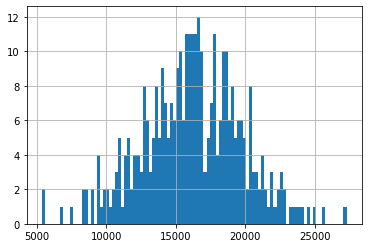

In [90]:
user_monthly_expense.query('tariff_name == "smart"')['total_mb_used'].hist(bins=100);

Распределение похоже на нормальное. Графики опять подтверждают разнородовость пользователей тарифа **Ultra**. Кто-то переплачивает за звонки, кто-то за интернет. Пользователи же траифа **Smart** более равномерно используют ресурсы.

Определим сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. 
По выборкам мы достаточно близко нашли параметры распределения для расхода звонков и интернет трафика - их распределения наиболее близко похожи на нормальное. 

Сначала зададим, для какой доли пользователей будем проводить расчёт необходимых ресурсов. <br>
Возьмём 80%. Это достаточно много, чтобы тариф пользовался спросом, но также останется часть пользователей, которые будут доплачивать за ресурсы сверх пакета.

In [91]:
threshold = 0.8

In [92]:
print('{:.2%} пользователей тарифа "Ultra" требуется менее {:.0f} минут разговора в месяц.'
      .format(threshold,
              st.norm(user_monthly_expense.query('tariff_name == "ultra"')['total_duration'].mean(),
        user_monthly_expense.query('tariff_name == "ultra"')['total_duration'].std()).ppf(threshold)))

80.00% пользователей тарифа "Ultra" требуется менее 722 минут разговора в месяц.


In [93]:
print('{:.2%} пользователей тарифа "Smart" требуется менее {:.0f} минут разговора в месяц.'
      .format(threshold,
              st.norm(user_monthly_expense.query('tariff_name == "smart"')['total_duration'].mean(),
        user_monthly_expense.query('tariff_name == "smart"')['total_duration'].std()).ppf(threshold)))

80.00% пользователей тарифа "Smart" требуется менее 511 минут разговора в месяц.


In [94]:
print('{:.2%} пользователей тарифа "Ultra" требуется менее {:.0f} Гб интернета в месяц.'
      .format(threshold,
              np.ceil(st.norm(user_monthly_expense.query('tariff_name == "ultra"')['total_mb_used'].mean(),
        user_monthly_expense.query('tariff_name == "ultra"')['total_mb_used'].std()).ppf(threshold))/1024))

80.00% пользователей тарифа "Ultra" требуется менее 26 Гб интернета в месяц.


In [95]:
print('{:.2%} пользователей тарифа "Smart" требуется менее {:.0f} Гб интернета в месяц.'
      .format(threshold,
              np.ceil(st.norm(user_monthly_expense.query('tariff_name == "smart"')['total_mb_used'].mean(),
        user_monthly_expense.query('tariff_name == "smart"')['total_mb_used'].std()).ppf(threshold))/1024))

80.00% пользователей тарифа "Smart" требуется менее 19 Гб интернета в месяц.


In [96]:
print('{:.2%} пользователей тарифа "Ultra" требуется менее {:.0f} сообщений в месяц.'
      .format(threshold,
              user_monthly_expense.query('tariff_name == "ultra"')['total_messages'].quantile(q=threshold)))

80.00% пользователей тарифа "Ultra" требуется менее 90 сообщений в месяц.


In [97]:
print('{:.2%} пользователей тарифа "Smart" требуется менее {:.0f} сообщений в месяц.'
      .format(threshold,
              user_monthly_expense.query('tariff_name == "smart"')['total_messages'].quantile(q=threshold)))

80.00% пользователей тарифа "Smart" требуется менее 56 сообщений в месяц.


#### Вывод:####
Статистика показывает, что более 80% пользователей дешевого тарифа **Smart** не хватает включенных в абонентскую плату услуг: звонков, сообщений, интернет трафика. Есть смысл предложить им перейти на более дорогой тариф **Ultra**. На этом тарифе им точно хватит включенных в абонентскую плату услуг и не придётся доплачивать. Хотя и оставаясь на дешевом тарифе большАя часть пользователей переплачивает сверх абонентской платы. Возможно это тоже приносит неплохой доход. Рассмотрим эту гипотезу.

### Шаг 4. Проверка гипотез

Проверим пару гипотез:
1. средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
2. средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

Для проверки первой гипотезы посмотрим на статистические параметры распределения выручки пользователей разных тарифов:

In [98]:
user_monthly_expense.query('tariff_name == "ultra"')['money_spent'].describe()

count     148.000000
mean     2086.464659
std       298.532720
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1990.625000
max      3225.000000
Name: money_spent, dtype: float64

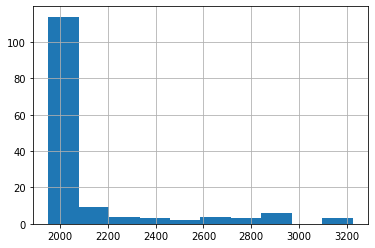

In [99]:
user_monthly_expense.query('tariff_name == "ultra"')['money_spent'].hist(bins=10);

In [100]:
user_monthly_expense.query('tariff_name == "smart"')['money_spent'].describe()

count     350.000000
mean     1290.469448
std       591.991797
min       550.000000
25%       847.317812
50%      1150.000000
75%      1650.000000
max      4240.423333
Name: money_spent, dtype: float64

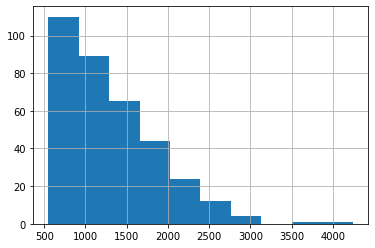

In [101]:
user_monthly_expense.query('tariff_name == "smart"')['money_spent'].hist(bins=10);

Сразу видно подтверждение предыдущего вывода - пользователи более дешевого тарифа чаще переплачивают.

Сформулируем гипотезы. Нулевую гипотезу с использованием равенства и альтернативную. <br>
Гипотеза H₀: средняя выручка пользователей тарифов **Ultra** и **Smart** одинакова <br>
Альтернативная гипотеза H₁: средняя выручка пользователей тарифов **Ultra** и **Smart** различается

Примем пороговое значение *p-value* равным 5%

In [102]:
alpha = 0.05

In [103]:
results = st.ttest_ind(
    user_monthly_expense.query('tariff_name == "ultra"')['money_spent'], 
    user_monthly_expense.query('tariff_name == "smart"')['money_spent'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
    if user_monthly_expense.query('tariff_name == "ultra"')['money_spent'].mean() > user_monthly_expense.query('tariff_name == "smart"')['money_spent'].mean():
        print('Средняя выручка пользователей тарифа "Ultra" больше')
    else:
        print('Средняя выручка пользователей тарифа "Smart" больше')
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.208930442744315e-44
Отвергаем нулевую гипотезу
Средняя выручка пользователей тарифа "Ultra" больше


Как видно, пользователи тарифа **Ultra** приносят компании больший доход. Пользователи тарифа **Smart**, переплачивая за недостающие в пакете минуты, сообщения и Гигабайты всё равно приносят дохода меньше.

Для проверки второй гипотезы посмотрим на статистические параметры распределения выручки пользователей разных городов:

In [104]:
user_monthly_expense.query('city == "Москва"')['money_spent'].describe()

count      99.000000
mean     1475.721682
std       608.340583
min       550.000000
25%       945.927000
50%      1570.003750
75%      1950.000000
max      2867.685000
Name: money_spent, dtype: float64

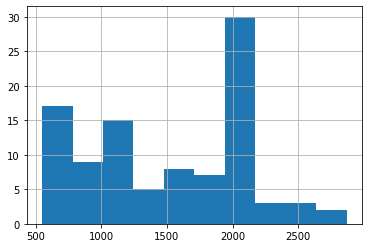

In [105]:
user_monthly_expense.query('city == "Москва"')['money_spent'].hist();

In [106]:
user_monthly_expense.query('city != "Москва"')['money_spent'].describe()

count     399.000000
mean     1539.760976
std       643.330565
min       550.000000
25%       978.646667
50%      1550.193333
75%      1950.000000
max      4240.423333
Name: money_spent, dtype: float64

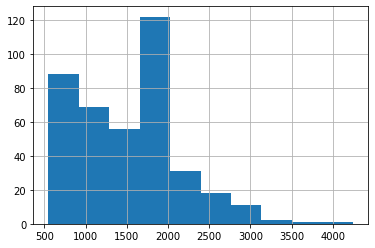

In [107]:
user_monthly_expense.query('city != "Москва"')['money_spent'].hist();

По гистограмам видно, что в Москве преобладают пользователи более дорого тарифа, а в других городах преобладают пользователи более дешевых тарифов. Хотя рекорды выручки ставят пользователи не из Москвы.

Сформулируем гипотезы. Нулевую гипотезу с использованием равенства и альтернативную. <br>
Гипотеза H₀: средняя выручка пользователей из Москвы и других городов одинакова <br>
Альтернативная гипотеза H₁: средняя выручка пользователей из Москвы и других городов различается

In [108]:
results = st.ttest_ind(
    user_monthly_expense.query('city == "Москва"')['money_spent'], 
    user_monthly_expense.query('city != "Москва"')['money_spent'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
    if user_monthly_expense.query('city == "Москва"')['money_spent'].mean() > user_monthly_expense.query('city != "Москва"')['money_spent'].mean():
        print('Средняя выручка пользователей из Москвы больше')
    else:
        print('Средняя выручка пользователей не из Москвы больше')
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.3707072828177076
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что хотя средняя выручка пользователей из разных городов и неодинакова, с вероятностью в 38% такое различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средней выручкой в Москве и других городах.

#### Вывод:####
Провели 2 статистических теста и выяснили, что гипотеза "средняя выручка пользователей тарифов **Ultra** и **Smart** одинакова" отвергается, а гипотезу что "средняя выручка пользователей из Москвы и других городов одинакова" отвергнуть не получилось.

### Шаг 5. Общий вывод.

В данном исследовании мы выяснили, что многим пользователям (более 20%) не хватает включенных в абонентскую плату тарифа **Smart** услуг. Пользователям приходится переплачивать и оператору сотовой связи есть смысл порекомендовать этим пользователям перейти на более дорогой тариф с большим объёмом услуг включенным в абонентскую плату.<br>
Пользователи тарифа **Ultra** приносят компании больший доход, чем пользователи тарифа **Smart**. <br>
У тарифа **Ultra** очень большой запас по количеству включенных в него минут разговоров и сообщений. 80% пользователей этого тарифа хватает 722 минут (в тариф включено 3000 минут) и 80 сообщений (в тариф включено 1000). Возможно оператору стоит снизить количество включенных в тариф ресурсов, чтобы пользователи доплачивали. Или оставить как "маркетинговый ход", всё равно многе пользователи это не используют и убытков компании это не приносит - всё зависит от политики компании. А вот количество включенного интернет трафика 30 Гб почти в обрез - 80% пользователей хватает 26 Гб. <br>
Стоит отметить среди пользователей тарифа **Ultra** тех, кто не использует звонки и сообщения - возможно их симкарты установлены в планшетах или модемах. На данный момент это небольшой сегмент на тарифе, который более ориентирован на интернет - возможно стоит подумать над развитием данного сегмента. <br>
Пользователи из столицы в среднем приносят компании такой же доход, как и пользователи из других городов.
